In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('TMDB_movie_dataset_v11.csv')  # Adjust path

# Select columns (no 'cast', using 'popularity' as proxy)
data = data[['title', 'budget', 'revenue', 'genres', 'popularity']]

# Clean data
data = data.dropna(subset=['budget', 'revenue', 'genres', 'popularity'])
data = data[(data['budget'] > 0) & (data['revenue'] > 0)]

# Encode genres
data['genres'] = data['genres'].str.split(', ')
genres_expanded = data['genres'].explode()
genres_dummies = pd.get_dummies(genres_expanded).groupby(level=0).sum()

# Combine features
data = pd.concat([data[['title', 'budget', 'revenue', 'popularity']], genres_dummies], axis=1)

# Log-transform budget and revenue
data['log_budget'] = np.log1p(data['budget'])
data['log_revenue'] = np.log1p(data['revenue'])

print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (12881, 25)
             title     budget     revenue  popularity  Action  Adventure  \
0        Inception  160000000   825532764      83.952       1          1   
1     Interstellar  165000000   701729206     140.241       0          1   
2  The Dark Knight  185000000  1004558444     130.643       1          0   
3           Avatar  237000000  2923706026      79.932       1          1   
4     The Avengers  220000000  1518815515      98.082       1          1   

   Animation  Comedy  Crime  Documentary  ...  Music  Mystery  Romance  \
0          0       0      0            0  ...      0        0        0   
1          0       0      0            0  ...      0        0        0   
2          0       0      1            0  ...      0        0        0   
3          0       0      0            0  ...      0        0        0   
4          0       0      0            0  ...      0        0        0   

   Science Fiction  TV Movie  Thriller  War  Western  log_budget  log_r

In [2]:
# Feature: Number of genres
data['genre_count'] = data[genres_dummies.columns].sum(axis=1)

# Feature set
features = ['log_budget', 'popularity', 'genre_count'] + list(genres_dummies.columns)
X = data[features]
y = data['log_revenue']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
mae_original = mean_absolute_error(y_test_exp, y_pred_exp)

print(f'Mean Absolute Error (log scale): {mae_log:.2f}')
print(f'R² Score: {r2:.2f}')
print(f'Mean Absolute Error (original scale): ${mae_original:,.0f}')

Mean Absolute Error (log scale): 1.38
R² Score: 0.82
Mean Absolute Error (original scale): $37,672,624


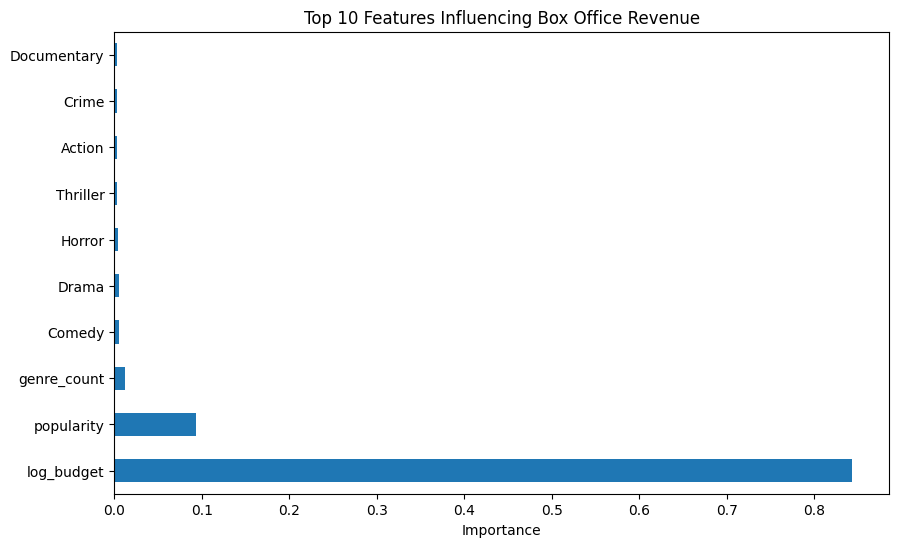

Top 5 Features:
log_budget     0.843324
popularity     0.093983
genre_count    0.012255
Comedy         0.005287
Drama          0.005033
dtype: float64


In [4]:
import matplotlib.pyplot as plt

# Feature importance
importance = pd.Series(model.feature_importances_, index=features)
importance_sorted = importance.sort_values(ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
importance_sorted.head(10).plot(kind='barh')
plt.title('Top 10 Features Influencing Box Office Revenue')
plt.xlabel('Importance')
plt.show()

print("Top 5 Features:")
print(importance_sorted.head(5))